In [1]:
from card_game import CardGame, Player, Card
import random
from agents import REINFORCEAgent, ACAgent
from tqdm import tqdm
import numpy as np
import torch as t
from typing import Tuple, Union
from harry_plotter import LearningCurvePlot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import asyncio
from tqdm.notebook import tqdm

cividis = cm.get_cmap('cividis')
viridis = cm.get_cmap('viridis')
%matplotlib widget
player = 1

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%pip install ipympl

Note: you may need to restart the kernel to use updated packages.


In [3]:
!jupyter nbextension enable --py --sys-prefix ipympl

Enabling notebook extension jupyter-matplotlib/extension...
      - Validating: ok


In [4]:
class RandomPlayer(Player):
    """
    Makes random moves (but according to the rules)
    """
    def __init__(self):
        global player
        self.number = player
        player += 1

    def make_move(self, game_state: dict, was_previous_move_wrong: bool) -> Card:
        if not game_state["discard"]:
            return random.choice(game_state["hand"])
        else:
            options = list(filter(lambda card: card.suit == list(game_state["discard"])[0].suit, game_state["hand"]))
            if len(options) > 0:
                return random.choice(options)
            else:
                return random.choice(game_state["hand"])

    def get_name(self):
        return f"RandomPlayer{self.number}"

    def set_temp_reward(self, discarded_cards: dict, point_deltas: dict):
        pass

    def set_final_reward(self, points: dict):
        pass


In [5]:
min_loss = float('inf')
min_loss_actor = float('inf')
min_loss_critic = float('inf')

In [6]:
def plot_loss(loss: float, agent: REINFORCEAgent, plot:LearningCurvePlot):
    global min_loss
    if min_loss > loss: 
        min_loss = loss
        t.save(agent.qnet, "reinforce.pkt")
        print(f"Upgraded loss to: {loss}")
    plot.update({'REINFORCE loss':{'Actor':loss}})
    
def plot_loss_ac(loss: Tuple[float, float], agent: ACAgent, plot:LearningCurvePlot):
    global min_loss_actor, min_loss_critic
    actor, critic = loss
    if min_loss_actor > actor: 
        min_loss_actor = actor
        t.save(agent.actor, "ac_actor.pkt")
        print(f"Upgraded actor loss to: {actor}")
    if min_loss_critic > critic: 
        min_loss_critic = critic
        t.save(agent.critic, "ac_critic.pkt")
        print(f"Upgraded critic loss to: {critic}")
    plot.update({'One-Step Actor Critic loss':{'Actor':actor, "Critic":critic}})
    
def plot_invalid_actions(invalid_actions_count: int, agent: Union[REINFORCEAgent, ACAgent], plot: LearningCurvePlot):
    name = 'One-Step AC-Agent' if isinstance(agent, ACAgent) else 'REINFORCE-Agent'
    plot.update({'Invalid Actions':{name:invalid_actions_count}})

In [7]:
agent = ACAgent(False, 1e-3, 1e-3, actor_layers=[256, 256, 128, 64], critic_layers=[256, 256, 128, 64])
agent_2 = REINFORCEAgent(256, False, 5e-4, importance_weighting=True, queue_size=524288, layers=[256, 256, 128, 64])
players = []
for i in range(2):
    # p = REINFORCEAgent(128, False, 5e-3, layers=[256, 256, 128, 64], queue_size=42024, importance_weighting=True)
    # p.qnet = t.load("reinforce_256_128_128_64_small_deck.pkt")
    # p.toggle_training(False)
    # p.requires_grad_(False)
    # p.eval()
    # players.append(p)
    players.append(RandomPlayer())

game = CardGame(agent, agent_2, *players, full_deck=False, display=False)

72 24


In [8]:
agent_2

REINFORCEAgent(
  (qnet): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=24, bias=True)
      (1): Identity()
    )
  )
)

In [9]:
agent

ACAgent(
  (actor): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=24, bias=True)
      (1): Identity()
    )
  )
  (critic): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=

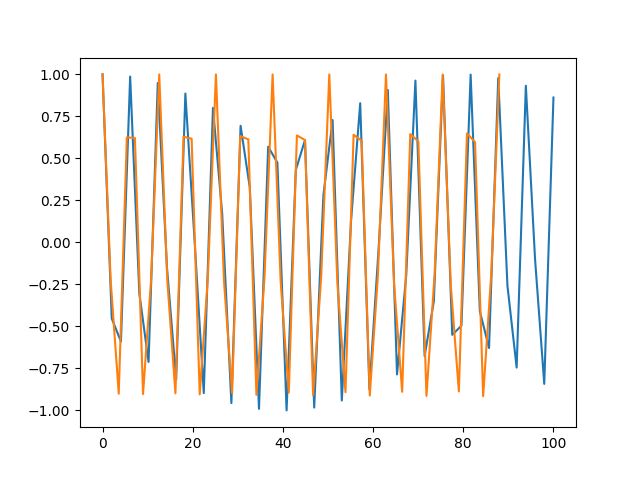

In [10]:
fig = plt.figure(5)

x_1 = np.linspace(0, 100)
x_2 = np.linspace(0, 88)

y_1 = np.cos(x_1)
y_2 = np.cos(x_2)

line_1 = plt.plot(x_1[:50], y_1[:50])[0]
line_2 = plt.plot(x_2[:50], y_2[:50])[0]

line_1.set_data(x_1, y_1)
line_2.set_data(x_2, y_2)

plt.gca().relim()
plt.gca().autoscale_view()
fig.canvas.draw()

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

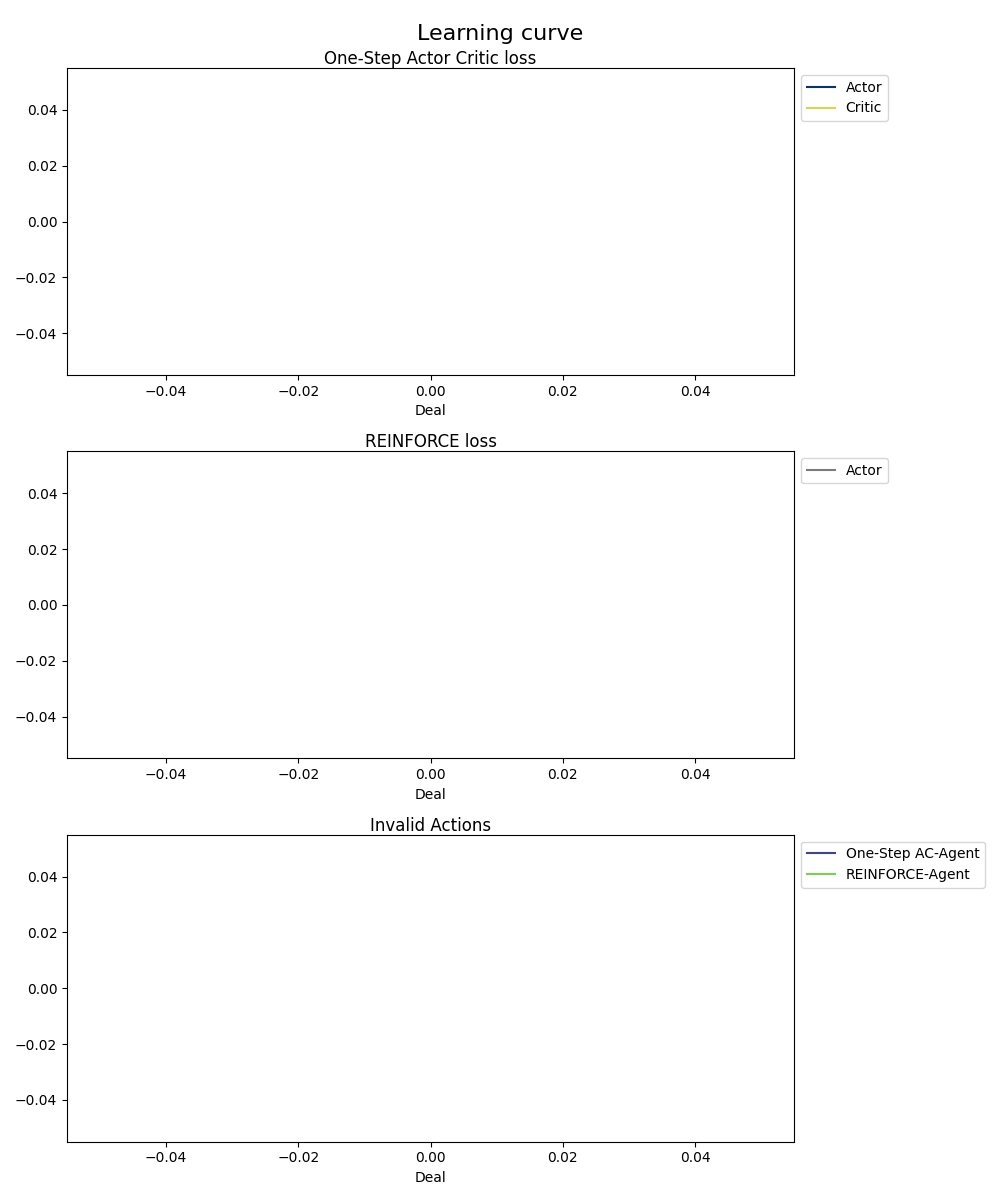

In [11]:
loop = tqdm(range(10000), desc="Episodes", position=0)
plot = LearningCurvePlot(plot_names=['One-Step Actor Critic loss', 'REINFORCE loss', "Invalid Actions"],
                         line_names={'One-Step Actor Critic loss':['Actor', 'Critic'], 'REINFORCE loss':['Actor'], 'Invalid Actions':['One-Step AC-Agent', 'REINFORCE-Agent']},
                         line_colors={'One-Step Actor Critic loss':[cividis(0.1), cividis(0.9)], 'REINFORCE loss':[cividis(0.5)], 'Invalid Actions':[viridis(0.2), viridis(0.8)]},
                         x_label='Deal')
agent.set_loss_callback(lambda x: plot_loss_ac(x, agent, plot))
agent.set_invalid_actions_callback(lambda x: plot_invalid_actions(x, agent, plot))
agent_2.set_loss_callback(lambda x: plot_loss(x, agent_2, plot))
agent_2.set_invalid_actions_callback(lambda x: plot_invalid_actions(x, agent_2, plot))

async def learn():
    await asyncio.sleep(1)
    for _ in loop:
        game.start()
        loop.set_postfix({'REINFORCE loss':agent_2.losses[-1] if agent_2.losses else float('inf'), "Actor loss":agent.losses[-1][0] if agent.losses else float('inf'), "Critic loss":agent.losses[-1][1] if agent.losses else float('inf')})
        await asyncio.sleep(0.1)

task = asyncio.get_event_loop().create_task(learn())

In [12]:
await task

Upgraded actor loss to: 285.7782367877071
Upgraded critic loss to: 92.2741948882698
Upgraded loss to: 3218.8477691493727
Upgraded critic loss to: 92.21773344821607
Upgraded critic loss to: 90.87358663337571
Upgraded critic loss to: 90.55769653466282
Upgraded critic loss to: 87.89677856243881
Upgraded critic loss to: 87.39563124221932
Upgraded critic loss to: 86.6629443475072
Upgraded loss to: 3073.394755650301
Upgraded loss to: 3036.2284218543946
Upgraded loss to: 2928.504637305128
Upgraded loss to: 2642.8145932170746
Upgraded critic loss to: 85.66445785899495
Upgraded loss to: 2614.3845837680774
Upgraded loss to: 2134.278242264684
Upgraded loss to: 1850.4529736045029
Upgraded loss to: 1437.4430208988952
Upgraded critic loss to: 84.28322179397432
Upgraded loss to: 1247.6160062873319
Upgraded loss to: 1105.317069754986
Upgraded critic loss to: 82.45447036304644
Upgraded loss to: 924.4462689223922
Upgraded loss to: 773.5340177265036
Upgraded loss to: 612.2096166609442
Upgraded loss to: 3

In [ ]:
agent.training = False
agent.set_loss_callback(lambda x:x)

In [ ]:
agent.actor = t.load('ac_actor.pkt')
agent.critic = t.load('ac_critic.pkt')

In [ ]:
game = CardGame(agent, RandomPlayer(), RandomPlayer(), RandomPlayer(), full_deck=False, display=False)

In [ ]:
wins = 0

Task exception was never retrieved
future: <Task finished name='Task-4' coro=<learn() done, defined at C:\Users\Kamil Chrustowski\AppData\Local\Temp\ipykernel_26352\1171040213.py:7> exception=ZeroDivisionError('division by zero')>
Traceback (most recent call last):
  File "C:\Users\Kamil Chrustowski\AppData\Local\Temp\ipykernel_26352\1171040213.py", line 12, in learn
    plot2.update({'One-Step Actor Critic loss':{'Actor':np.cosh(i), "Critic":1/i}, 'REINFORCE loss':{'Actor':np.tanh(i)}, 'Invalid Actions':{'One-Step AC-Agent':np.sinh(i), 'REINFORCE-Agent':np.arccosh(i)}})
ZeroDivisionError: division by zero


In [ ]:
test_loop = tqdm(range(100), desc='Episodes')
for _ in test_loop:
	points = game.start()
	wins += int(np.min(list(points.values())) == points[agent])
print(f"Win ratio: {wins}%")

Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
game = CardGame(agent, *players, full_deck=False, display=False)
test_loop = tqdm(range(100), desc='Episodes')
for _ in test_loop:
	wins += int(np.argmin(list(game.start().values())) == 0)
print(f"Win ratio: {wins}%")

In [ ]:
plt.plot(agent.invalid_actions_per_episode[-100:])

In [ ]:
import matplotlib.pyplot as plt
import asyncio


fig = plt.figure()

async def update():
    for i in range(5):
        print(i)
        x = list(range(i + 2))
        xx = [x**2 for x in x]
        plt.clf()
        plt.plot(x, xx)
        fig.canvas.draw()
        await asyncio.sleep(1)


loop = asyncio.get_event_loop()
loop.create_task(update());